In [9]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.9.1
torchvision version: 0.24.1


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps"
device

'mps'

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"Train dir: {train_dir}")
print(f"Test dir: {test_dir}")

Train dir: data/pizza_steak_sushi/train
Test dir: data/pizza_steak_sushi/test


In [7]:
train_dir =image_path /"train"
test_dir =image_path /"test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [8]:
from going_modular.going_modular import data_setup
IMAGE_SIZE =224
manual_transforms = transforms.Compose([ transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.ToTensor() ])

In [9]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# 1. Define the transform (Recalling the fix: Capital 'R' for Resize)
IMAGE_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# 2. Create DataLoaders using the paths you just defined
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

# 3. Check the output
print(f"Class names: {class_names}")
print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

Class names: ['pizza', 'steak', 'sushi']
Train dataloader length: 8
Test dataloader length: 3


In [10]:
import shutil
from pathlib import Path
from going_modular.going_modular import data_setup # Import your custom module

# 1. Force delete the existing data folder to clear the error
data_path = Path("data/pizza_steak_sushi")
if data_path.exists():
    shutil.rmtree(data_path)
    print(f"Deleted corrupted directory: {data_path}")

# 2. Re-download the data (Copying the download function logic here to ensure it runs)
import requests
import zipfile

# Setup path to data folder
data_root = Path("data/")
image_path = data_root / "pizza_steak_sushi"
image_path.mkdir(parents=True, exist_ok=True)

# Download
with open(data_root / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip
with zipfile.ZipFile(data_root / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# 3. Define paths again
train_dir = image_path / "train"
test_dir = image_path / "test"

# 4. Create DataLoaders immediately to verify it works
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Uses the transforms we fixed earlier
    batch_size=32
)

print("\nSuccess! Data loaded.")
print(f"Classes found: {class_names}")

Deleted corrupted directory: data/pizza_steak_sushi
Unzipping pizza, steak, sushi data...

Success! Data loaded.
Classes found: ['pizza', 'steak', 'sushi']


In [11]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # Uses the transforms we fixed earlier
    batch_size=32
)
len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

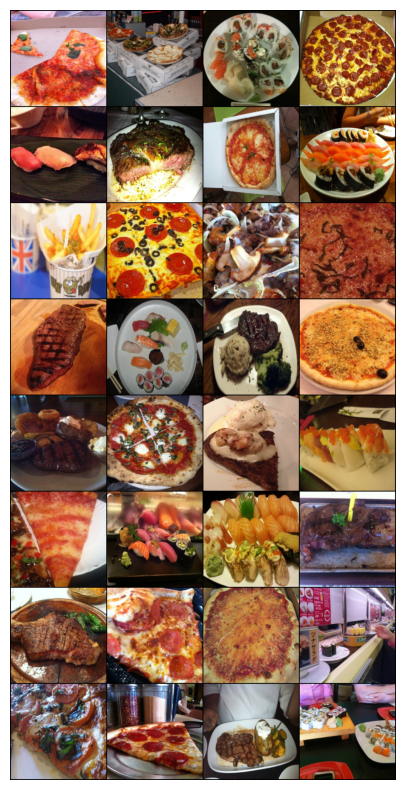

(8, 3, ['pizza', 'steak', 'sushi'])

In [13]:
#Visualize some data
import matplotlib.pyplot as plt
# Get a batch of images and labels
image, labels = next(iter(train_dataloader))
# Create a grid of images
img_grid = torchvision.utils.make_grid(image, nrow=4)
# Plot the grid
plt.figure(figsize=(10,10))
plt.imshow(img_grid.permute(1, 2, 0))  # Change from
plt.axis('off')
plt.show()  
len(train_dataloader), len(test_dataloader), class_names


In [14]:
# Set random seeds for reproducibility
set_seeds(42)

In [16]:
# Replicate the model architecture from the paper
height=224
width = 224
color_channels= 3
patch_size=16
number_of_patches=int((height*width)/patch_size**2)


In [17]:
#input_shape
embedding_layer_input_shape=(height,width,color_channels)
# output chape
embedding_layer_output_shape=(number_of_patches,patch_size**2 * color_channels)

print(f"Input shape(Single 2D image):{embedding_layer_input_shape}")
print(f"Output shape(after patching and flattening):{embedding_layer_output_shape}")

Input shape(Single 2D image):(224, 224, 3)
Output shape(after patching and flattening):(196, 768)


In [18]:
!pip install matplotlib

In [19]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

image_permuted=image_permuted(1,2,0)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

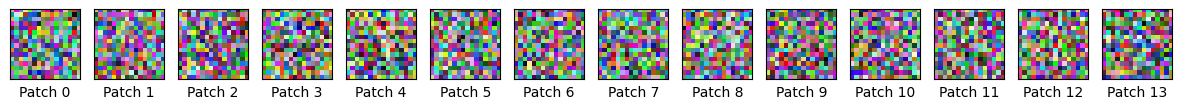

In [20]:
import torch
import matplotlib.pyplot as plt

# 1. إعداد المتغيرات الأساسية
image_size = 224
patch_size = 16

# 2. إنشاء المتغير المفقود 'image' (تنسور عشوائي يمثل صورة)
# الأبعاد في PyTorch تكون: (القنوات اللونية، الارتفاع، العرض)
image = torch.rand(3, image_size, image_size) 

# 3. السطر الذي كان يعطيك الخطأ (الآن سيعمل لأن 'image' موجود)
# نقوم بتغيير الترتيب ليكون (الارتفاع، العرض، القنوات) ليفهمه matplotlib
image_permuted = image.permute(1, 2, 0).numpy()

# 4. باقي الكود الخاص بك
num_patches = (image_size * image_size) // (patch_size**2)
assert image_size % patch_size == 0 

# إنشاء الرسم
fig, axs = plt.subplots(nrows=1, ncols=image_size // patch_size, 
                        figsize=(15, 2), # قمت بتكبير حجم الرسم قليلاً للوضوح
                        sharex=True, sharey=True)

for i, patch in enumerate(range(0, image_size, patch_size)):
    # هنا يتم عرض المربعات القُطرية (Diagonal)
    axs[i].imshow(image_permuted[patch:patch+patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(f"Patch {i}") # تسمية للتوضيح
    axs[i].set_xticks([]) # إخفاء الأرقام للمظهر الجمالي
    axs[i].set_yticks([])
    axs[i].imshow(image_permuted[patch:patch+patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(f"Patch {i}") # تسمية للتوضيح
    axs[i].set_xticks([]) # إخفاء الأرقام للمظهر الجمالي
    axs[i].set_yticks([])

plt.show()

In [21]:
image_batch,label_batch= next(iter(train_dataloader))
image, label=image_batch[0], label_batch[0]
image.shape,label

(torch.Size([3, 224, 224]), tensor(1))

In [22]:
img_size=224
patch_size=16
num_patches=(img_size*img_size)//(patch_size**2)
assert img_size % patch_size ==0
#img_size,patch_size,num_patches



In [23]:
# Create subpolts
fig , axs =plt.subplots( nrows=img_size // patch_size,ncols=img_size // patch_size, figsize=(num_patches,num_patches),sharex=True, sharey=True)
#loop through rows and columns of subplots
for i ,patch_hight in enumerate(range(0,img_size,patch_size)):
    for j ,patch_width in enumerate(range(0,img_size,patch_size)):
        axs[i,j].imshow(image.permute(1,2,0)[patch_hight:patch_hight +patch_size, patch_width:patch_width +patch_size,:])
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

In [24]:
from torch import nn 
patch_size= 16
conv2d= nn.Conv2d(in_channels =3 ,out_channels =768,kernel_size=patch_size,stride=patch_size)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

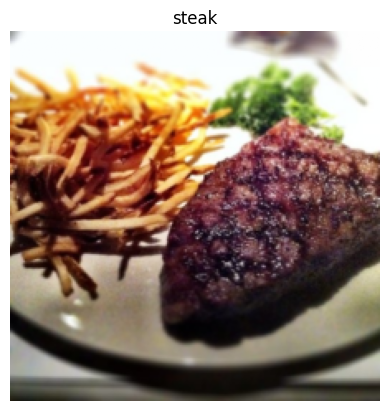

In [25]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [27]:
image_out_of_conv=conv2d(image.unsqueeze(0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [28]:
image_out_of_conv.requires_grad

True

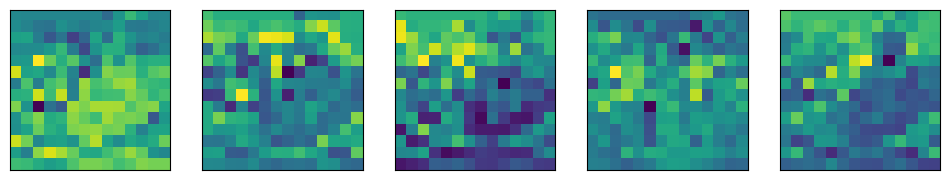

In [29]:
import random 
reandom_indexs=random.sample(range(0,758),k=5)
fig ,axs = plt.subplots(nrows=1,ncols=5 ,figsize=(12,12))
for i ,idx in enumerate(reandom_indexs):
    image_conv_feature_map=image_out_of_conv[:,idx,:,:]
    axs[i].imshow(image_conv_feature_map.detach().squeeze().numpy())
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    

In [30]:
single_feature_map=image_out_of_conv[:,0,:,:]
single_feature_map.shape

torch.Size([1, 14, 14])

In [31]:
flatten_layer=nn.Flatten(start_dim=2,end_dim=3)
flatten_layer(image_out_of_conv)

tensor([[[-0.1382, -0.1327, -0.1326,  ..., -0.0247, -0.0453, -0.0461],
         [ 0.0494,  0.0440,  0.0436,  ..., -0.0409, -0.0849, -0.0927],
         [ 0.6620,  0.7337,  0.7335,  ...,  0.2844,  0.4147,  0.4149],
         ...,
         [ 0.0505,  0.0846,  0.0846,  ..., -0.0660, -0.0541, -0.0416],
         [-0.4185, -0.4037, -0.4037,  ..., -0.0556, -0.0641, -0.0663],
         [ 0.1001,  0.1402,  0.1404,  ..., -0.0206, -0.0700, -0.0641]]],
       grad_fn=<ViewBackward0>)

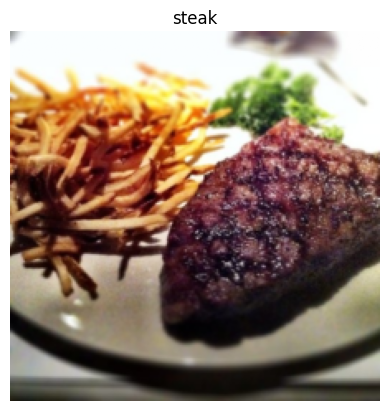

In [32]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
image_out_of_conv=conv2d(image.unsqueeze(0))
image_out_of_conv_flattened=flatten_layer(image_out_of_conv)

In [33]:
image_out_of_conv_flattened_permuted=image_out_of_conv_flattened.permute(0,2,1)

In [34]:
single_flatten_map=image_out_of_conv_flattened_permuted[:,:,0]
single_flatten_map

tensor([[-0.1382, -0.1327, -0.1326, -0.1327, -0.1335, -0.1320, -0.1327, -0.1323,
         -0.1168, -0.0632, -0.1230, -0.0326, -0.0452, -0.1293, -0.1137, -0.0887,
         -0.1219, -0.1230, -0.1207, -0.0085, -0.1183, -0.1047, -0.1137, -0.1884,
         -0.0396, -0.1536, -0.0829, -0.1308, -0.0146, -0.1057, -0.0661, -0.0235,
         -0.0064, -0.0324, -0.0296, -0.0478, -0.1809, -0.1451, -0.0652,  0.1020,
         -0.1269, -0.0720,  0.0216, -0.0292, -0.0966,  0.0522,  0.0499,  0.0166,
         -0.0863, -0.0064,  0.1706, -0.0884, -0.0889,  0.2406, -0.1117, -0.1304,
          0.1642,  0.0486,  0.1781,  0.0451,  0.0482,  0.0280,  0.1785,  0.0985,
         -0.1288,  0.0288,  0.0036, -0.0296, -0.0524, -0.1120,  0.0985, -0.0271,
         -0.0932,  0.0930,  0.0941,  0.1276, -0.0229, -0.0373, -0.0308, -0.0019,
          0.1268,  0.0457,  0.0224,  0.0359,  0.1000, -0.0134, -0.1024, -0.0918,
          0.0455,  0.0232, -0.1318, -0.0317, -0.0134, -0.0698, -0.0286, -0.0235,
         -0.1004, -0.0413, -

In [35]:
plt.figure(figsize=(22,22))
plt.imshow(single_flatten_map.detach().numpy())
plt.axis(False);

In [36]:
class PatchEmbedding(nn.Module):
    def __init__ (self,in_channels:int =3,patch_size:int=16,embedding_dim:int=768):
        super().__init__()
        self.patch_size=patch_size
        self.patcher= nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten=nn.Flatten(start_dim=2,end_dim=3)
    def forward(self,x):
        image_resolution=x.shape[-1]
        assert image_resolution % patch_size==0 , f"Image resolution {image_resolution} must be divisible by patch size {patch_size}"
        x_patched =self.patcher(x)
        x_flattened=self.flatten(x_patched)
        
        return x_flattened.permute(0,2,1)  # (batch_size, num_patches, embedding_dim)

In [37]:
set_seeds(42)
patchify=PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)
patch_embedded_image=patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [38]:
rand_image_tensor= torch.randn(1,3,224,224 )
rand_image_tensor_bad= torch.randn(1,3,225,224 )  # Bad image size
patchify(rand_image_tensor)
#patchify(rand_image_tensor_bad)  # This should raise an assertion error

tensor([[[-0.3601,  0.2602, -0.7408,  ..., -1.2910, -0.2012, -0.0354],
         [-0.3405,  0.6132,  0.6626,  ..., -0.6314, -1.8604,  0.3311],
         [-0.0176, -0.2323, -0.1009,  ...,  0.1873,  0.6899, -0.5419],
         ...,
         [ 0.5333, -0.7641, -0.1217,  ...,  0.2381,  0.5565,  0.0466],
         [-0.6577, -0.0324, -0.6278,  ..., -0.1591,  0.7905,  1.4529],
         [-1.1716, -0.1617, -0.1427,  ...,  0.5600,  0.4640,  0.7539]]],
       grad_fn=<PermuteBackward0>)

In [39]:
# Creating the class token embedding 
# we want to prepend a learnable class token to the start of patch embedding 
batch_size=patch_embedded_image.shape[0]
embedding_dimension=patch_embedded_image.shape[-1]
batch_size, embedding_dimension


(1, 768)

In [40]:
# Create class token embedding 
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
class_token.shape


torch.Size([1, 1, 768])

In [41]:
patch_embedded_image.shape[0]

1

In [42]:
# Add the class token to the patch embeddings
patch_embedded_image_with_class_embedding=torch.cat((class_token,patch_embedded_image),dim=1)
patch_embedded_image_with_class_embedding.shape

torch.Size([1, 197, 768])

In [43]:
# Creating the position embeddings
#Calculate the N umber of patches +1 for class token
number_of_patches= int((height*width)/patch_size**2)
#height, width, patch_size, number_of_patches
# Get the embedding dimension from the patch embedded image
embedding_dimension=patch_embedded_image_with_class_embedding.shape[-1]
# Create position embedding 
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)
position_embedding.shape


torch.Size([1, 197, 768])

In [44]:
# Add the position embeddings to the patch embeddings + class token
patch_and_position_embedded=patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedded.shape

torch.Size([1, 197, 768])

In [45]:
manual_seeds=42
set_seeds(manual_seeds)
patch_size=16
print(f"image tensor shape:{image.shape}")
height, width= image.shape[1], image.shape[2]
x=image.unsqueeze(0)
print(f"input image batch shape:{x.shape}")
# create patch embedding layer
patch_embedding_layer=PatchEmbedding(in_channels=3,patch_size=patch_size,embedding_dim=768)
# pass the input image batch through patch embedding layer
patch_embedding=patch_embedding_layer(x)
print(f"patch embedded image shape:{patch_embedding.shape}")
#create class token embedding
batch_size=patch_embedding.shape[0]
embedding_dimension=patch_embedding.shape[-1]
class_token=nn.Parameter(torch.ones(batch_size,1,embedding_dimension),requires_grad=True)
print(f"class token embedding shape:{class_token.shape}")
patch_embedding_class_token=torch.cat((class_token,patch_embedding),dim=1)
print(f"patch embedding with class token shape:{patch_embedding_class_token.shape}")
# create position embedding
number_of_patches=int((height*width)/patch_size**2)
position_embedding=nn.Parameter(torch.ones(1,number_of_patches+1,embedding_dimension),requires_grad=True)
print(f"position embedding shape:{position_embedding.shape}")
# add position embedding to patch embedding + class token
patch_and_position_embedding=patch_embedding_class_token + position_embedding
print(f"patch and position embedding shape:{patch_and_position_embedding.shape}")




image tensor shape:torch.Size([3, 224, 224])
input image batch shape:torch.Size([1, 3, 224, 224])
patch embedded image shape:torch.Size([1, 196, 768])
class token embedding shape:torch.Size([1, 1, 768])
patch embedding with class token shape:torch.Size([1, 197, 768])
position embedding shape:torch.Size([1, 197, 768])
patch and position embedding shape:torch.Size([1, 197, 768])


In [51]:
class MultiHeadSelfAttentionBlock (nn.Module):
        
        def __init__(self,embedding_dim:int=768,num_heads:int=12,attn_dropout:int=0):
            super().__init__()
            #Create norm layer
            self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
            #Create multi head self attention layer
            self.multihead_attn=nn.MultiheadAttention(embed_dim=embedding_dim,num_heads=num_heads,dropout=attn_dropout,batch_first=True)
            
        def forward(self,x):
            x=self.layer_norm(x)
            attn_output, _ =self.multihead_attn(query=x,key=x,value=x,need_weights=False)
            return attn_output
            
            
            
            
    

In [54]:
multihead_self_attention_block=MultiHeadSelfAttentionBlock(embedding_dim=768,num_heads=12,attn_dropout=0)
multihead_self_attention_block
patched_image_through_mas_block=multihead_self_attention_block(patch_and_position_embedded)
patched_image_through_mas_block.shape

torch.Size([1, 197, 768])